# 1. Autores

# 2. Abstract

# 3. Keywords

# 4. Introdução

O cerrado brasileiro possui uma grande diversidade de aves. Algumas delas apresentam um desenvolvimento cerebral maior que outras, como é o caso das aves da família Psittacidae. Diversas aves dessa família são conhecidas como papagaios, araras e periquitos.bEssas aves possuem inteligência superior em comparação às demais, sendo capazes de imitar diferentes sons. Caracterizam-se por um bico alto e curvo, com a parte superior maior que a inferior, além de apresentarem plumagens muito coloridas. Embora sejam bastante bonitas, podem ser difíceis de diferenciar a olho nu por pessoas que não possuem certas especializações. Com o objetivo de facilitar esse processo, a presente rede convolucional tem como finalidade analisar e identificar a espécie da ave a partir de uma imagem.

Para isso, será criada e treinada uma rede convolucional utilizando um conjunto de dados com mais de 3.000 imagens, obtidas a partir do site iNaturalist. O dataset possui diferentes quantidades de imagens para cada espécie e, a fim de equilibrar as classes, serão adicionadas novas imagens, além da aplicação de técnicas de data augmentation.

As especies a serem utilizadas no treinamento serão:

*   Amazona aestiva
*   Amazona amazonica
*   Anodorhynchus hyacinthinus
*   Ara ararauna
*   Ara chloropterus
*   Ara macao
*   Brotogeris chiriri
*   Diopsittaca nobilis
*   Eupsittula aurea
*   Forpus xanthopterygius
*   Orthopsittaca manilatus
*   Primolius maracana
*   Psittacara leucophthalmus
*   Touit melanonotus

Uma rede convolucional funciona a partir de três camadas principais: a camada convolucional, a camada de agrupamento e a camada totalmente conectada. A camada convolucional tem como objetivo dividir a imagem em regiões e aplicar filtros a partir de pesos aprendidos. A camada de agrupamento aplica um filtro sem pesos de treinamento na entrada, a fim de reduzir a quantidade de informações, mantendo apenas as mais relevantes. Por fim, a camada totalmente conectada realiza a classificação e retorna ao usuário a informação final.

A fim de comparar a rede criada, também será realizado o transfer learning a partir de uma arquitetura já consolidada, seguido do fine-tuning. Dessa forma, o resultado final compreenderá três redes convolucionais. A arquitetura utilizada para criar a rede convolucional será a ResNet50; para o transfer learning será empregada a XXXX; e, para o fine-tuning, será aplicada a técnica XXXX.

# 5. Trabalhos Relacionados

# 6. Metodologia

## 6.1 Imports

Esta célula faz o import das bibliotecas que serão utilizadas no notebook.


In [2]:
import gdown
import zipfile
import os
import shutil
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 6.2 Download do dataset original

Nesta etapa realizamos o processo completo de obtenção e organização do conjunto de dados.  
O arquivo compactado é baixado do Google Drive por meio da biblioteca **gdown**, armazenado em uma pasta de arquivos **compactados** e, em seguida, descompactado para a pasta **dataset_original**. Após a extração, diretórios e arquivos temporários do sistema (como `__MACOSX` e `.DS_Store`) são removidos, garantindo uma estrutura limpa e padronizada.  

Ao final, temos um dataset pronto para uso, organizado em `datasets/` e pronto para os próximos passos.


In [3]:
file_id = "19rWCGW38ht8TLY1ad7gba46mP5FCIZul"
url = f"https://drive.google.com/uc?id={file_id}"
zip_name = "dataset_original.zip"

base = Path("datasets"); compact = base/"compactados"; extract = base/"dataset_original"
base.mkdir(exist_ok=True); compact.mkdir(parents=True, exist_ok=True); extract.mkdir(parents=True, exist_ok=True)

exts = {".jpg",".jpeg",".png",".bmp",".tiff",".tif",".webp"}
contar_imgs = lambda p: sum(1 for f in p.rglob("*") if f.is_file() and f.suffix.lower() in exts)

def pronto(p):
    return p.exists() and sum(1 for d in p.iterdir() if d.is_dir()) == 14 and contar_imgs(p) == 2879

if pronto(extract):
    print("✅ Dataset já existe.")
else:
    print("📥 Baixando..."); gdown.download(url, zip_name, quiet=False)
    dest = compact/zip_name; dest.unlink(missing_ok=True); shutil.move(zip_name, dest)
    print("📂 Extraindo..."); zipfile.ZipFile(dest).extractall(extract)
    [shutil.rmtree(d, ignore_errors=True) for d in extract.rglob("__MACOSX")]
    [f.unlink(missing_ok=True) for f in extract.rglob(".DS_Store")]
    print(f"📸 Total de imagens: {contar_imgs(extract)}")
    print("✅ Dataset pronto em:", base.resolve())


📥 Baixando...


Downloading...
From (original): https://drive.google.com/uc?id=19rWCGW38ht8TLY1ad7gba46mP5FCIZul
From (redirected): https://drive.google.com/uc?id=19rWCGW38ht8TLY1ad7gba46mP5FCIZul&confirm=t&uuid=c53924d6-03ad-4bc2-bab5-0f432ddc17a1
To: /content/dataset_original.zip
100%|██████████| 277M/277M [00:04<00:00, 58.8MB/s]


📂 Extraindo...
📸 Total de imagens: 2879
✅ Dataset pronto em: /content/datasets


## 6.3 Exploração de dados

### 6.3.1 Organização do dataset

In [4]:
dataset_path = "./datasets/dataset_original"

#### 6.3.1.1 Quantidade total de imagens

In [5]:
total_images = sum(len(files) for _, _, files in os.walk(dataset_path))
total_images

2879

#### 6.3.1.2 Número de classes (espécies)

In [6]:
classes = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
num_classes = len(classes)
num_classes

14

### 6.3.2 Distribuição das classes

#### 6.3.2.1 Frequência de imagens por classe com representação em quantidade e porcentagem

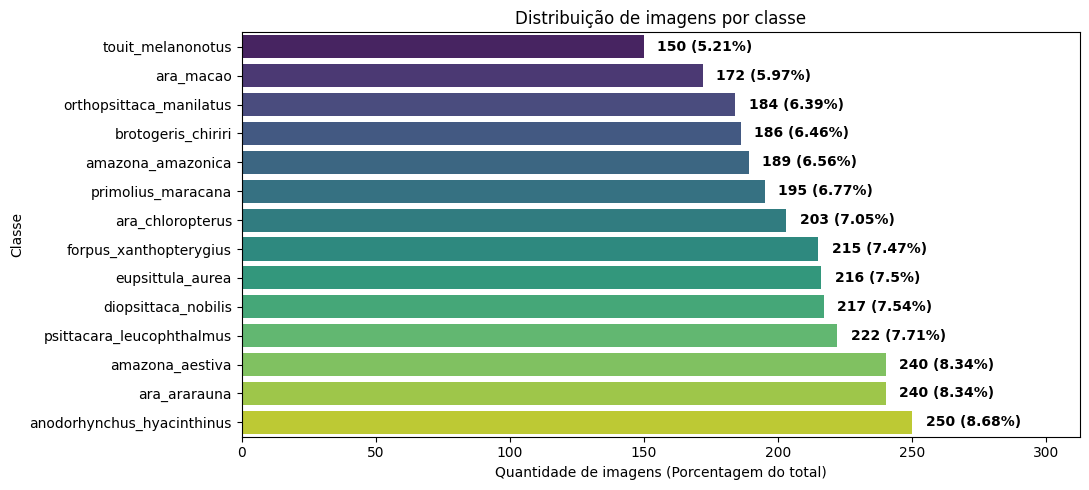

In [12]:
df = pd.DataFrame([
    (c, sum(1 for _,_,fs in os.walk(os.path.join(dataset_path, c))
            for f in fs if os.path.splitext(f)[1].lower() in exts))
    for c in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, c))
], columns=["classe","imagens"]).sort_values("imagens")

df["pct"] = (df["imagens"] / df["imagens"].sum() * 100).round(2)

plt.figure(figsize=(11,5))
ax = sns.barplot(data=df, x="imagens", y="classe",
                 hue="classe", dodge=False, palette="viridis",
                 orient="h", legend=False)

for i, p in enumerate(ax.patches):
    ax.text(p.get_width()+5, p.get_y()+p.get_height()/2,
            f"{int(p.get_width())} ({df['pct'].iloc[i]}%)",
            va="center", ha="left", weight="bold")

max_val = df["imagens"].max()
ax.set_xlim(0, max_val * 1.25)

ax.set(title="Distribuição de imagens por classe",
       xlabel="Quantidade de imagens e Porcentagem", ylabel="Classe")

plt.tight_layout()
plt.show()


# 7. Resultados

# 8. Conclusão

# 9. Referências